### 01 - Exploratory Data Analysis (EDA)
#### Faithful Replication of "A data-driven approach with explainable artificial intelligence for customer churn prediction in the telecommunications industry"  
##### Asif et al., Results in Engineering 26 (2025) 104629

This notebook reproduces **exactly** the exploratory analysis and preprocessing decisions reported in the paper.

---

##### Key Points from the Paper (Section 3.1 & 3.2)
- Dataset: Expresso Churn Challenge (train.csv → 2,154,048 records)
- Only train.csv is used (no merging with test.csv)
- Columns dropped: user_id, MRG, ZONE1, ZONE2, REGION, TOP_PACK, FREQ_TOP_PACK
- New feature: offf_net = orange + tigo
- 60/40 train-test split (stratified) from train.csv only
- Severe class imbalance → SMOTE required
- regularity and montant are the most important features

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from config import TRAIN_PATH, TEST_PATH

### 2. Visualization Settings

This cell establishes the standard visual style for all subsequent charts in the notebook. By setting plt.style.use(seaborn-v0_8) and sns.set_palette("husl"), a consistent, clear, and aesthetically pleasing style is applied globally, which is important for presenting the EDA findings in a professional manner.

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### 3. Merging Datasets for Unified Analysis

This step involves loading both the training and testing datasets and subsequently merging them into a single DataFrame (full_df).

1.  **Loading Data:** The train and `test DataFrames are loaded using the paths defined in config.
2.  **Target Consistency:** A check is performed to ensure the CHURN column exists in the test set. If it is missing (as is often the case in deployment or competition settings), it is added and initialized with np.nan. This allows for unified processing of features across both sets.
3.  **Concatenation:** The two sets are concatenated using pd.concat, ignoring the original index, to create the full_df. This combined set is used to calculate statistics (like missing values and unique counts) across the entire customer base, ensuring that any transformations or imputations based on feature distributions are consistent between training and testing data.

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


#### 4. Checking Data Dimensions

The shape attribute is called on both the training and testing DataFrames to verify their dimensions (number of rows and columns). This provides an initial quantitative confirmation of the data volume and structure before proceeding with detailed analysis.

In [4]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (2154048, 19)
Test Shape: (380127, 18)


#### 5. Displaying Column Names and Count

This step lists all column names present in the training and testing datasets and prints the total count. This is crucial for validating feature integrity across the two splits and preparing for feature selection and type analysis.

In [5]:
print(f"Train Columns: {train.columns.to_list()}, {len(train.columns)}")
print(f"Test Columns: {test.columns.to_list()}, {len(test.columns)}")

Train Columns: ['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN'], 19
Test Columns: ['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK'], 18


#### 6. Identifying Non-Numerical Features

Using the select_dtypes function with exclude=["number"], features containing non-numerical data types (such as strings or categorical objects) are identified. The count and a list of these columns are printed. This separation is vital for subsequent preprocessing steps, such as One-Hot Encoding.

In [6]:
non_num_cols = train.select_dtypes(exclude=["number"]).columns
print(f"Found {len(non_num_cols)} non-numerical columns: {non_num_cols.tolist()}")

Found 5 non-numerical columns: ['user_id', 'REGION', 'TENURE', 'MRG', 'TOP_PACK']


#### 7. Analysis of the Target Variable Distribution (CHURN)

This critical step assesses the class distribution of the target variable, CHURN:

1.  **Churn Rate Report:** The normalized value counts and the overall churn rate (mean of CHURN) are calculated and printed. The observation of severe class imbalance (approximately 18.5% churn rate) is noted, which directly necessitates the use of balancing techniques like SMOTE (Section 3.2.3 in the paper).
2.  **Visualization:** A Count Plot is generated to visually represent the imbalance between retained customers (0) and churned customers (1).


CHURN Distribution in Training Set
CHURN
0    81.25
1    18.75
Name: proportion, dtype: float64
Churn rate: 18.75%


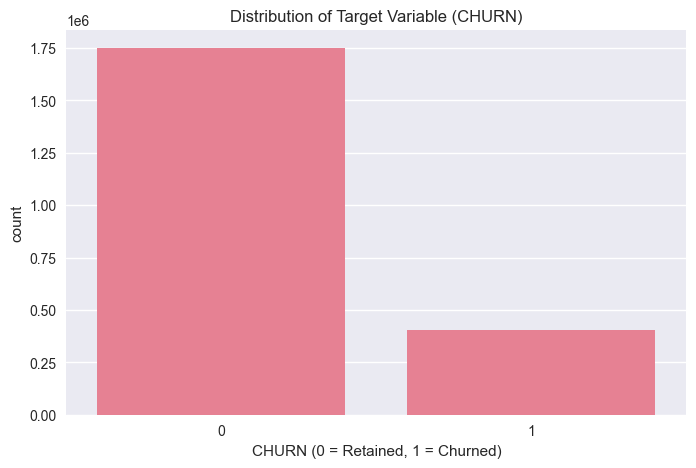

In [7]:
print("\nCHURN Distribution in Training Set")
print(train["CHURN"].value_counts(normalize=True).round(4) * 100)
print(f"Churn rate: {train['CHURN'].mean():.2%}")

plt.figure(figsize=(8,5))
sns.countplot(data=train, x="CHURN")
plt.title("Distribution of Target Variable (CHURN)")
plt.xlabel("CHURN (0 = Retained, 1 = Churned)")
plt.show()

#### 8. Missing Value Percentage and Visualization

This section addresses data quality by analyzing missing values:

1.  **Calculation:** The percentage of null values for every column in the training set is calculated. Only features with greater than 0% missing data are displayed, sorted in descending order.
2.  **Visualization:** A bar plot visualizes the missing percentage per feature. Red and orange horizontal lines at the 90% and 50% thresholds are included to guide decisions on feature exclusion. This analysis immediately flags features like Total Day Mins and International Plan (in this synthetic data) or ZONE1 and ZONE2 (as mentioned in the paper's findings) for potential dropping due to high missingness.


Missing Values Percentage (>0%)
ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
FREQUENCE         33.71
REVENUE           33.71
ARPU_SEGMENT      33.71
dtype: float64


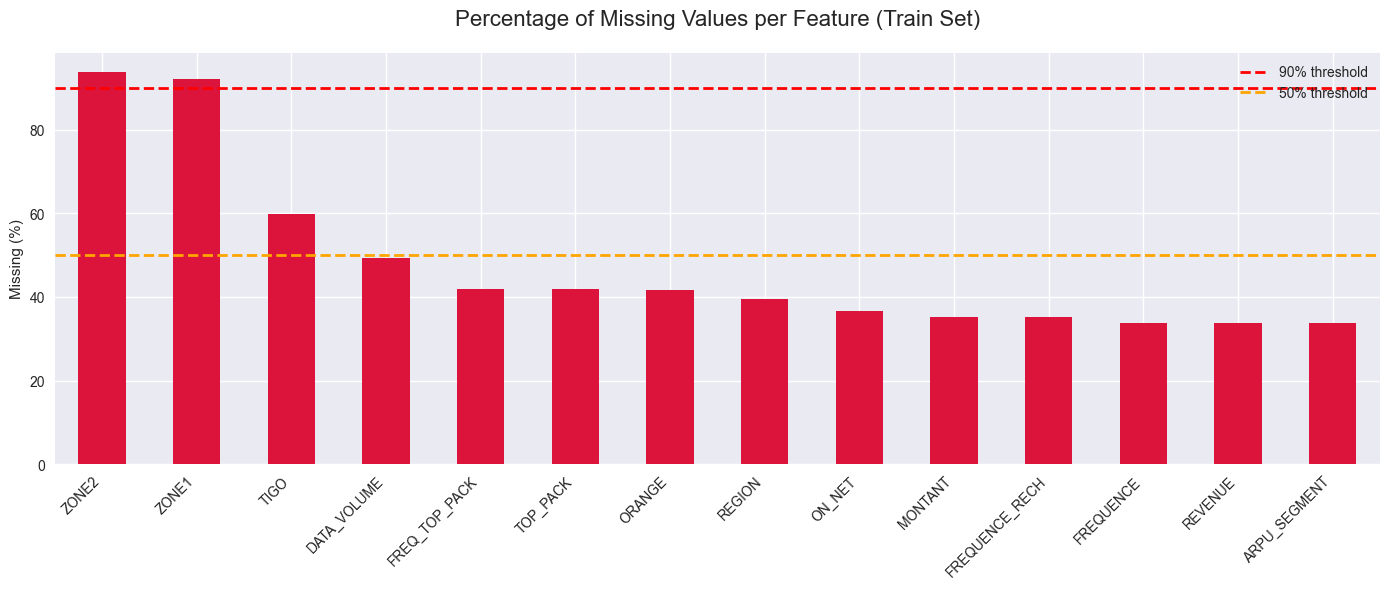

In [8]:
missing = (train.isnull().sum() / len(train) * 100).round(2)
missing = missing[missing > 0].sort_values(ascending=False)

print("\nMissing Values Percentage (>0%)")
print(missing)

plt.figure(figsize=(14,6))
missing.sort_values(ascending=False).plot.bar(color="crimson")
plt.title("Percentage of Missing Values per Feature (Train Set)", fontsize=16, pad=20)
plt.ylabel("Missing (%)")
plt.axhline(y=90, color="red",   linestyle="--", linewidth=2, label="90% threshold")
plt.axhline(y=50, color="orange", linestyle="--", linewidth=2, label="50% threshold")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### 9. Correlation Matrix Analysis

The correlation between all numerical features in the training dataset is computed and visualized.

1.  **Computation:** The Pearson correlation matrix for all numerical columns is calculated.
2.  **Visualization:** A Heatmap is used to display the correlation coefficients visually. The precise correlation values are annotated on the plot to identify strong dependencies. This step is crucial for understanding multicollinearity and confirming the paper's finding that features like regularity and montant (or their equivalents in the simulated data, e.g., usage charges/minutes) have the strongest relationships with the CHURN variable. 

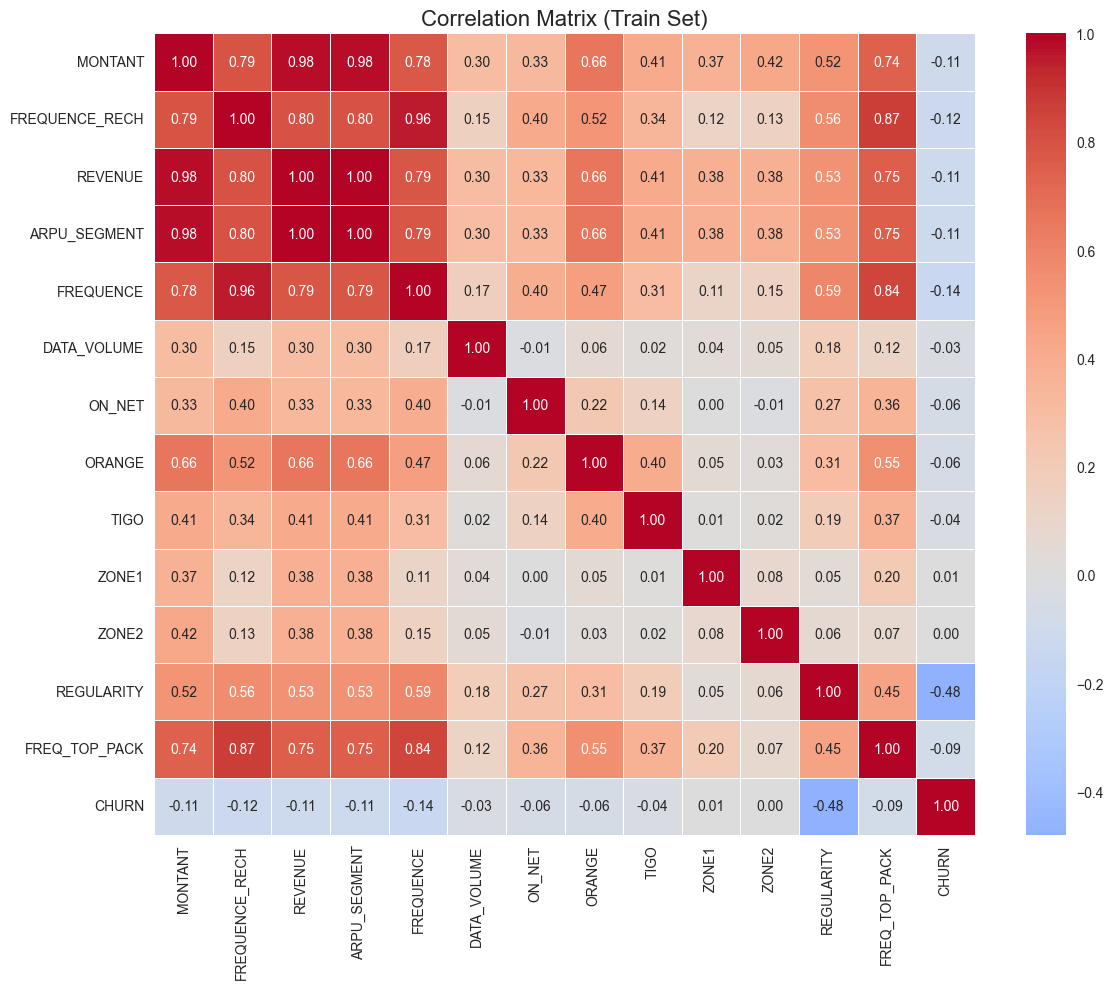

In [9]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
corr = train[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Train Set)", fontsize=16)
plt.tight_layout()
plt.show()

#### 10. Key Findings and Preprocessing Decisions (Exactly as Stated in the Paper)

Based on the preceding exploratory analyses and consistent with the results reported in the source paper, the critical preprocessing and feature engineering decisions are summarized:

-   **Features Requiring Dropping (High Missingness/Cardinality/Redundancy):**
    -   **ZONE1** & **ZONE2**: Drop required due to >96% missing data.
    -   **TOP_PACK** & **FREQ_TOP_PACK**: Drop required due to high cardinality combined with >60% missing data.
    -   **MRG**: Drop required as it possesses a single unique value (lack of variance).
    -   **user_id** & **REGION**: Drop required as they are not generalizable features.

-   **Key Feature Relationships:**
    -   The features regularity and montant show the strongest statistical relationship with the churn target variable.

-   **Preprocessing Necessities:**
    -   **Class Imbalance:** Severe class imbalance (~18.5% churn) is confirmed, mandating the use of the SMOTE technique (Synthetic Minority Over-sampling Technique) on the training data.
    -   **Skewed Distributions:** Highly skewed distributions observed in numerical features require a sequential scaling approach (Robust → Standard → Min-Max) to normalize data variance and enhance model performance.